In [7]:
from custom_models.CustomViT import CustomViT
from custom_models.CustomViTMAE import CustomViTMAE
import torch
# call CustomViT
from transformers import AutoImageProcessor, ViTMAEForPreTraining, ViTMAEConfig
from PIL import Image

# output_dir='/home/tyz/Desktop/11_777/camelmera/weights'
# trained_model_name = 'multimodal_AbandonedFactoryExposure'
trained_model_name = 'multimodal'
output_dir='/home/ubuntu/weights/' + trained_model_name

# Initialize a new CustomViT model
model_name = "facebook/vit-mae-base"
vit_config = ViTMAEConfig.from_pretrained(model_name)
vit_config.output_hidden_states=True
vit_model = CustomViT(config=vit_config)

# Initialize a new CustomViTMAE model
model_name = "facebook/vit-mae-base"
config = ViTMAEConfig.from_pretrained(model_name)
config.output_hidden_states=True
custom_model = CustomViTMAE(config=config)
custom_model.vit = vit_model

# Load the state_dict from the saved model
state_dict = torch.load(f"{output_dir}/pytorch_model.bin")
custom_model.load_state_dict(state_dict)

# don't need decoders
vit_encoder = custom_model.vit

In [3]:
from dataloader import process_image,process_depth,process_lidar

environment_name = 'AbandonedFactoryExposure'
dataset_dir = f'/mnt/data/tartanairv2filtered/{environment_name}/Data_easy'

# pixel_values = process_image('/home/tyz/Desktop/11_777/Data_easy/P000/image_lcam_fish/000000_lcam_fish_image.png').unsqueeze(0).cuda()
# pixel_values1 = process_depth('/home/tyz/Desktop/11_777/Data_easy/P000/depth_lcam_fish/000000_lcam_fish_depth.png').unsqueeze(0).cuda()
# pixel_values2 = process_lidar('/home/tyz/Desktop/11_777/Data_easy/P000/lidar/000000_lcam_front_lidar.ply').unsqueeze(0).cuda()
pixel_values = process_image(dataset_dir+'/P000/image_lcam_fish/000000_lcam_fish_image.png').unsqueeze(0).cuda()
pixel_values1 = process_depth(dataset_dir+'/P000/depth_lcam_fish/000000_lcam_fish_depth.png').unsqueeze(0).cuda()
pixel_values2 = process_lidar(dataset_dir+'/P000/lidar/000000_lcam_front_lidar.ply').unsqueeze(0).cuda()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
from tem_dataloader import process_image,process_depth,process_lidar
from PIL import Image 

custom_model.cuda()
custom_model.eval()
with torch.no_grad():
    outputs = custom_model(pixel_values,pixel_values1,pixel_values2)
    print(outputs.loss)

tensor(1.9851, device='cuda:0')


In [9]:
print(outputs.logits.shape)
tensor=custom_model.unpatchify(outputs.logits)
print(tensor.shape)

torch.Size([1, 196, 768])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


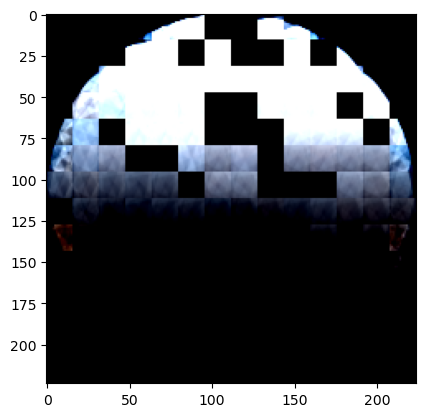

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert the tensor to a NumPy array and transpose the dimensions to HWC
image = tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()

# Visualize the image using Matplotlib
plt.imshow(image)
plt.show()

In [12]:
import numpy as np

observations = np.load('/home/ubuntu/camelmera/models/gym/multimodal/trajectories/all_observations_P001.npy')
np.min(observations)
np.max(observations)

11.99885368347168

In [18]:
actions = np.load('/home/ubuntu/camelmera/models/gym/multimodal/trajectories/all_actions_P001.npy')
print(np.max(actions,axis=0))
print(np.min(actions,axis=0))

[0.49747467 0.41341591 0.30998468 0.03764978 0.05789059 0.0546096
 0.04920381]
[-0.47627258 -0.47770309 -0.29711241 -0.03317956 -0.05373394 -0.04548082
 -0.03906822]


In [20]:
min_val = observations.min(axis=0)
max_val = observations.max(axis=0)
# Rescale the array to the range (0, 1)
normalized_observations = (observations - min_val) / (max_val - min_val)
print(normalized_observations.shape)
# no need to normalize actions

(1055, 768)
